In [63]:
from jax import numpy as np
import matplotlib.pyplot as plt

waves = 0.5, a = 2.4674011002723395


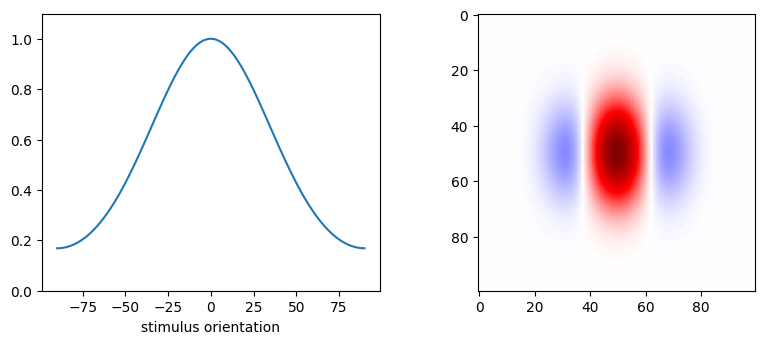

In [64]:
thets = np.linspace(-np.pi/2, np.pi/2, 100)
waves = .5 # number of waves in 2σ (full-width of Gabor)
sig_f = waves/2 
a = (2 * np.pi * sig_f)**2
print(f'{waves = }, {a = }')
fig, axs = plt.subplots(1, 2, figsize=np.array((8 * 2, 6)) * .6)
ax = axs[0]
ax.plot(thets * 180 / np.pi, np.cosh(a * np.cos(thets)) / np.cosh(a))
ax.set_ylim([0, 1.1]);
ax.set_xlabel('stimulus orientation')
ax.set_label(f'Isotropic Gabor tuning curve ({waves:.2}waves in 2σ)')
#ax.grid()
ax = axs[1]
xs = np.linspace(-4 * sig_f, 4 * sig_f, 100)
xs = np.meshgrid(xs, xs)
xs = np.array(xs)

gabor = np.exp(- 0.5 * np.sum(xs ** 2, axis=0) / sig_f**2)
gabor *= np.cos(2 * np.pi * xs[0])
ax.imshow(gabor, cmap='seismic', vmin=-np.abs(gabor).max(), vmax=np.abs(gabor).max())

In [65]:
class Gabor():
    """
    Gabor filters with specified orientation (theta), phase (phase), spatial frequency (k), 
    standard deviation (sigma), on an image pixelized to resol x resol. 
    You can optionally provide the nominal length (L) of the image as well.  
    If L is not provided, it is set to 20 * sigma.
    Also, instead of sigma, you can provide "waves" which is the number of waves contained within 2-σ
    width of the Gabor (more precisely, waves = 2 * sigma * k).
    """
    def __init__(self, theta, phase, k, sigma=None, resol=100, waves=0.5, x0=0, y0=0, L=None):
        self.theta = theta
        self.phase = phase
        self.k = k
        assert not (sigma is None and waves is None)
        self.sigma = sigma if waves is None else waves / 2 / k
        self.resol = resol
        self.L = L if L is not None else 20 * self.sigma
        self.x0 = x0
        self.y0 = y0
        self.filter = self.make_gabor()

    def make_gabor(self, theta=None, phase=None, k=None, sigma=None, waves=None, norm=True):
        theta = self.theta if theta is None else theta        
        phase = self.phase if phase is None else phase
        k = self.k if k is None else k
        sigma = self.sigma if sigma is None else sigma
        sigma = waves / 2 / k if waves is not None else sigma

        xs = np.linspace(-self.L/2, self.L/2, self.resol)
        xs = np.meshgrid(xs, xs)
        ys = xs[0].T
        xs = np.array(xs[0]) - self.x0
        ys = np.array(ys) - self.y0
        self.x = xs
        self.y = ys
        gabor = np.cos(2 * np.pi * k * (np.cos(theta) * xs + np.sin(theta) * ys) + phase)
        gabor *= np.exp(- 0.5 * (xs ** 2 + ys ** 2) / sigma**2)
        if norm:
             gabor /= 2 * np.pi * sigma**2

        return gabor

In [66]:
tc_integral = lambda θ, ks, kg, φs, φg, σ: np.exp(- 2 * σ**2 * np.pi**2 * (ks**2 + kg**2)) * (
                                np.cos(φs) * np.cos(φg) * np.cosh(4 * np.pi**2 * ks * kg * σ**2 * np.cos(θ)) +
                                np.sin(φs) * np.sin(φg) * np.sinh(4 * np.pi**2 * ks * kg * σ**2 * np.cos(θ)))

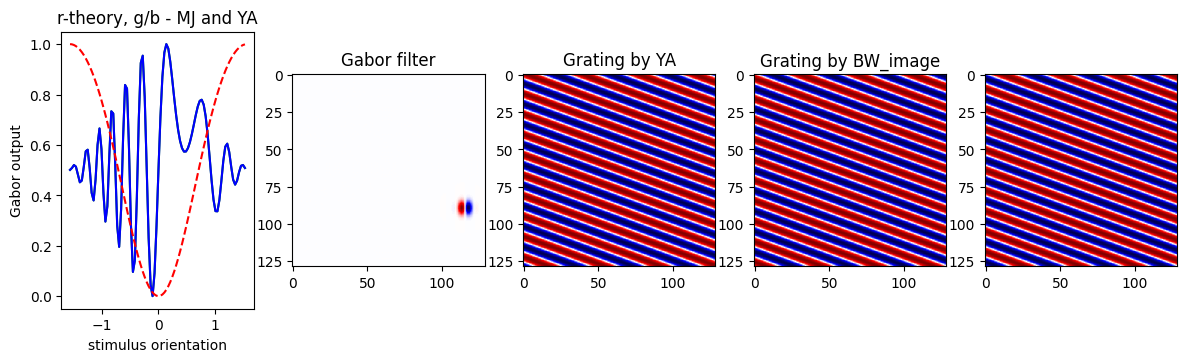

In [67]:
i= 0
num_oris = 90
ori_vec_rad = np.linspace(-np.pi/2, np.pi/2, num_oris, endpoint=False)

resol = 129
L=5

phase = np.pi/2 * 1
phase_s = 0
k=2
gabor = Gabor(theta=0,
              phase=phase,
              k=k, 
              waves=.45,      # number of waves in 2σ (full-width of Gabor)
              resol=resol, 
              x0=2,
              y0=1,
              L=L)

# Calculating the tuning curve
tun_curv_MJ = []
tun_curv_YA = []
xs = np.linspace(-L/2, L/2, resol)
xs = np.meshgrid(xs, xs)
x = np.array(xs[0]) 
y = xs[0].T
for i in range(num_oris):
    gabor_s = Gabor(theta=ori_vec_rad[i],
              phase=phase_s,
              k=k, 
              waves=100,      # number of waves in 2σ (full-width of Gabor)
              resol=resol, 
              x0=0,
              y0=0,
              L=L)
    angle = ori_vec_rad[i]
    grating_MJ = np.cos(2 * np.pi * k * (np.cos(angle) *x + np.sin(angle) * y) + phase_s)
    response_MJ = np.sum(gabor.filter * grating_MJ) * (gabor.L / gabor.resol)**2
    response_YA = np.sum(gabor.filter * gabor_s.filter) * (gabor.L / gabor.resol)**2
    tun_curv_MJ.append(response_MJ)
    tun_curv_YA.append(response_YA)
tun_curv_MJ = np.array(tun_curv_MJ)
tun_curv_YA = np.array(tun_curv_YA)


tc_theory = tc_integral(ori_vec_rad, k, gabor.k, phase_s, phase, gabor.sigma)

normalize = True
if normalize:
    tun_curv_MJ_norm = (tun_curv_MJ-tun_curv_MJ.min()) / (tun_curv_MJ.max()-tun_curv_MJ.min())
    tun_curv_YA_norm = (tun_curv_YA-tun_curv_YA.min()) / (tun_curv_YA.max()-tun_curv_YA.min())
    tc_theory_norm = (tc_theory-tc_theory.min()) / (tc_theory.max()-tc_theory.min())

########### Make a plot illustrating the results ###########
fig, axs = plt.subplots(1, 5, figsize=np.array((8 * 3, 6)) * .6)

axs[0].plot(ori_vec_rad, tun_curv_MJ_norm, 'g')
axs[0].plot(ori_vec_rad, tun_curv_YA_norm, 'b')
axs[0].plot(ori_vec_rad, tc_theory_norm, 'r--')
axs[0].set_xlabel("stimulus orientation")
axs[0].set_ylabel("Gabor output")
axs[0].set_title("r-theory, g/b - MJ and YA")

axs[1].imshow(gabor.filter, cmap='seismic', vmin=-np.abs(gabor.filter).max(), vmax=np.abs(gabor.filter).max())
axs[1].set_title('Gabor filter')

ori_ind = 10
angle = ori_vec_rad[ori_ind]
gabor_s = Gabor(theta=angle,
              phase=phase_s,
              k=k, 
              waves=100,      # number of waves in 2σ (full-width of Gabor)
              resol=resol, 
              x0=0,
              y0=0,
              L=L)
axs[2].imshow(gabor_s.filter, cmap='seismic')
axs[2].set_title('Grating by YA')

grating_fig = np.cos(2 * np.pi * k * (np.cos(angle) *x + np.sin(angle) * y) + phase)
axs[3].imshow(grating_fig, cmap='seismic')
axs[3].set_title('Grating by BW_image')

axs[4].imshow(gabor_s.filter-grating_fig , cmap='seismic', vmin=-np.abs(grating_fig).max(), vmax=np.abs(grating_fig).max())


In [68]:
def BW_image_jax_supp(stimuli_pars, phase=0.0):
    import numpy
    from jax import numpy as np
    """
    This function supports BW_image_jax (that generates grating images) by calculating variables that do not need to be recalculated in the training loop. 
    """     
    _BLACK = 0
    _WHITE = 255
    _GRAY = round((_WHITE + _BLACK) / 2)
    degree_per_pixel = stimuli_pars.degree_per_pixel
    pixel_per_degree = 1 / degree_per_pixel
    smooth_sd = pixel_per_degree / 6
    grating_size = round(stimuli_pars.outer_radius * pixel_per_degree)
    gridsize_deg = stimuli_pars.gridsize_deg
    size = int(stimuli_pars.gridsize_deg  * 2 * pixel_per_degree) + 1
    '''
    # Generate a 2D grid of coordinates
    x, y = numpy.mgrid[
        -grating_size : grating_size + 1.0,
        -grating_size : grating_size + 1.0,
    ]
    x_jax = np.array(x)
    y_jax = np.array(y)
    '''
    # following the same pattern as in gabor filter generation
    N_pixels = grating_size*2+1
    x_1D = np.linspace(-gridsize_deg, gridsize_deg, N_pixels, endpoint=True)
    x_1D = np.reshape(x_1D, (N_pixels,1))
    y_1D = np.linspace(-gridsize_deg, gridsize_deg, N_pixels, endpoint=True)
    y_1D = np.reshape(y_1D, (1,N_pixels))
    x_jax= np.repeat(x_1D, N_pixels, axis=1)    
    y_jax = np.repeat(y_1D, N_pixels, axis=0)
    
    # Calculate the distance from the center for each pixel
    x, y = numpy.mgrid[
        -grating_size : grating_size + 1.0,
        -grating_size : grating_size + 1.0,
    ]
    edge_control_dist = numpy.sqrt(numpy.power(x, 2) + numpy.power(y, 2))
    edge_control = numpy.divide(edge_control_dist, pixel_per_degree)

    # Create a matrix (alpha_channel) that is 255 (white) within the inner_radius and exponentially fades to 0 as the radius increases
    overrado = edge_control > stimuli_pars.inner_radius
    d = grating_size * 2 + 1
    annulus = numpy.ones((d, d))
    exponent_part = -1 * ((edge_control[overrado] - stimuli_pars.inner_radius) * pixel_per_degree) ** 2 / (2 * (smooth_sd**2))
    annulus[overrado] *= numpy.exp(exponent_part)
    alpha_channel = annulus.reshape(d,d) * _WHITE
    alpha_channel_jax = np.array(alpha_channel)

    # Create a boolean mask for outside the grating size - this will be used to set pixels outside the grating size to _GRAY
    mask = (edge_control_dist > grating_size).reshape((2 * int(grating_size) + 1,2 * int(grating_size) + 1))
    mask_bool = np.array(mask, dtype=bool)

    # Define indices for bounding box
    center_x, center_y = size // 2, size // 2
    bbox_height = np.abs(center_x - grating_size)
    bbox_width = np.abs(center_y - grating_size)
    start_indices = (int(bbox_height), int(bbox_width))

    # Create gray background
    background_jax = np.full((size, size), _GRAY, dtype=np.float32)

    # Create a constant input for BW_image_jax
    print('k in BW_image_jax_supp', stimuli_pars.k)
    BW_image_const_inp = (stimuli_pars.k, stimuli_pars.grating_contrast, phase, stimuli_pars.std, start_indices, x_jax, y_jax, alpha_channel_jax, mask_bool, background_jax)
    
    return BW_image_const_inp

k in BW_image_jax_supp 2


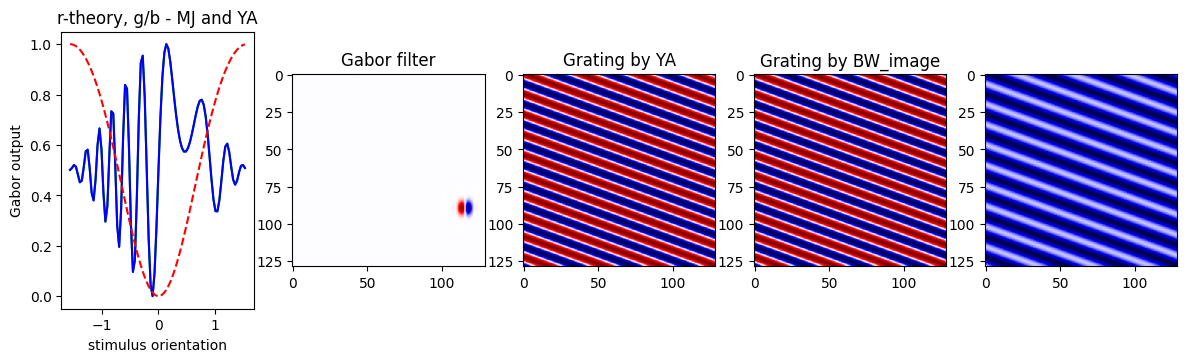

In [69]:
# Repeat but use the BW_image_full_vmap function
from training.util_gabor import BW_image_full_vmap
from parameters import stimuli_pars
i= 0
num_oris = 90
ori_vec_rad = np.linspace(-np.pi/2, np.pi/2, num_oris, endpoint=False)

resol = 129
L=5

phase = np.pi/2 * 1
phase_s = 0
k=2
stimuli_pars.k = k
gabor = Gabor(theta=0,
              phase=phase,
              k=k, 
              waves=.45,      # number of waves in 2σ (full-width of Gabor)
              resol=resol, 
              x0=2,
              y0=1,
              L=L)

# Calculating the tuning curve
tun_curv_MJ = []
tun_curv_YA = []
xs = np.linspace(-L/2, L/2, resol)
xs = np.meshgrid(xs, xs)
x = np.array(xs[0]) 
y = xs[0].T

xs_BW = np.linspace(-(resol-1)/2, (resol-1)/2, resol)
xs_BW = np.meshgrid(xs_BW, xs_BW)
x_BW = np.array(xs_BW[0]) 
y_BW = xs_BW[0].T

BW_image_const_inp = BW_image_jax_supp(stimuli_pars, phase=phase_s)
grating_MJ_all = BW_image_full_vmap(BW_image_const_inp, x, y, ori_vec_rad*180/np.pi+90, np.zeros(num_oris))
for i in range(num_oris):
    gabor_s = Gabor(theta=ori_vec_rad[i],
              phase=phase_s,
              k=k, 
              waves=100,      # number of waves in 2σ (full-width of Gabor)
              resol=resol, 
              x0=0,
              y0=0,
              L=L)
    grating_MJ = np.reshape(grating_MJ_all[i,:],(resol,resol))
    angle = ori_vec_rad[i]
    grating_MJ2 = np.cos(2 * np.pi * k* (x * np.cos(angle) + y * np.sin(angle) ) + 0 )
    response_MJ = np.sum(gabor.filter * grating_MJ) * (gabor.L / gabor.resol)**2
    response_YA = np.sum(gabor.filter * gabor_s.filter) * (gabor.L / gabor.resol)**2
    tun_curv_MJ.append(response_MJ)
    tun_curv_YA.append(response_YA)
tun_curv_MJ = np.array(tun_curv_MJ)
tun_curv_YA = np.array(tun_curv_YA)


tc_theory = tc_integral(ori_vec_rad, k, gabor.k, phase_s, phase, gabor.sigma)

normalize = True
if normalize:
    tun_curv_MJ_norm = (tun_curv_MJ-tun_curv_MJ.min()) / (tun_curv_MJ.max()-tun_curv_MJ.min())
    tun_curv_YA_norm = (tun_curv_YA-tun_curv_YA.min()) / (tun_curv_YA.max()-tun_curv_YA.min())
    tc_theory_norm = (tc_theory-tc_theory.min()) / (tc_theory.max()-tc_theory.min())

# Make a plot illustrating the results
fig, axs = plt.subplots(1, 5, figsize=np.array((8 * 3, 6)) * .6)

axs[0].plot(ori_vec_rad, tun_curv_MJ_norm, 'g')
axs[0].plot(ori_vec_rad, tun_curv_YA_norm, 'b')
axs[0].plot(ori_vec_rad, tc_theory_norm, 'r--')
axs[0].set_xlabel("stimulus orientation")
axs[0].set_ylabel("Gabor output")
axs[0].set_title("r-theory, g/b - MJ and YA")

axs[1].imshow(gabor.filter, cmap='seismic', vmin=-np.abs(gabor.filter).max(), vmax=np.abs(gabor.filter).max())
axs[1].set_title('Gabor filter')

ori_ind = 10
angle = ori_vec_rad[ori_ind]
gabor_s = Gabor(theta=angle,
              phase=phase_s,
              k=k, 
              waves=100,      # number of waves in 2σ (full-width of Gabor)
              resol=resol, 
              x0=0,
              y0=0,
              L=L)
axs[2].imshow(gabor_s.filter, cmap='seismic')
axs[2].set_title('Grating by YA')

grating_fig = np.reshape(grating_MJ_all[ori_ind,:],(resol,resol))
axs[3].imshow(grating_fig, cmap='seismic')
axs[3].set_title('Grating by BW_image')

axs[4].imshow(gabor_s.filter-grating_fig , cmap='seismic', vmin=-np.abs(grating_fig).max(), vmax=np.abs(grating_fig).max())
